In [1]:
%load_ext autoreload
%autoreload 2

import os
os.chdir(globals()['_dh'][0])
os.chdir('..')
# print(os.path.abspath(os.curdir))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import sqrt
from dataset_utils import generate_train_mixture, generate_competition_eval_mixture
from dataset_utils import SigSepDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scipy.stats import binned_statistic

import os

2024-04-05 10:31:38.758677: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-05 10:31:38.794010: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
class CausalConv1d(nn.Module):
    def __init__(self, in_channels,
                 out_channels, kernel_size, dilation, bias=True):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                              padding=self.padding, dilation=dilation, bias=bias)

    def forward(self, x):
        x = self.conv(x)
        if self.padding != 0:
            x = x[:, :, :-self.padding]
        return x

        
class ResidualBlock(nn.Module):
    def __init__(self, residual_channels, dilation):
        super(ResidualBlock, self).__init__()
        # TODO: replace with learnable dilation and padding 1D convolution
        self.dilated_conv = nn.Conv1d(
            residual_channels, 2 * residual_channels, 3, padding=dilation, dilation=dilation)
        self.conv1x1 = nn.Conv1d(residual_channels, 2 * residual_channels, 1)
        self.norm = nn.BatchNorm1d(residual_channels)

    def forward(self, x):
        residual = x
        x = self.dilated_conv(x)

        gate, filter = torch.chunk(x, 2, dim=1)
        x = torch.sigmoid(gate) * torch.tanh(filter)

        x = self.conv1x1(x)
        x, skip = torch.chunk(x, 2, dim=1)

        return self.norm(x + residual), skip


class WaveNet(nn.Module):
    def __init__(self, input_channels=2,
                 residual_channels=512,
                 residual_layers=30, dilation_cycle_length=10):
        super(WaveNet, self).__init__()
        self.input_projection = CausalConv1d(
            input_channels, residual_channels, 1, 1)

        self.residual_layers = nn.ModuleList([
            ResidualBlock(residual_channels, 3**(i % dilation_cycle_length))
            for i in range(dilation_cycle_length)])

        self.skip_projection = nn.Conv1d(
            residual_channels, residual_channels, 1)
        self.output_projection = nn.Conv1d(
            residual_channels, input_channels, 1)

    def forward(self, x):
        x = self.input_projection(x)
        skip = None
        for layer in self.residual_layers:
            x, s = layer(x)
            skip = s if skip is None else skip + s

        # normalize with sqrt(num_residual_layers)
        x = skip / sqrt(len(self.residual_layers))
        x = F.relu(skip)
        x = self.skip_projection(x)
        x = F.relu(x)
        x = self.output_projection(x)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"Using device: {}".format(device)

'Using device: cuda'

In [5]:
# load the training and validation datasets

batch_size = 4
num_batches = 50
soi_type = "QPSK"

# dataset_path = generate_train_mixture(
#     batch_size=batch_size, num_batches=num_batches, soi_type=soi_type,
#     intrf_path_dir="rf_datasets/train_test_set_unmixed/dataset/interferenceset_frame")

In [6]:
dataset_path = "rf_datasets/train_set_mixed/datasets/QPSK_20240405_081820"
filelists_path = [os.path.join(dataset_path, file) for file in os.listdir(dataset_path)]
# dataset = SigSepDataset(filelists_path, dtype="real")
dataset = SigSepDataset(filelists_path, dtype="real")
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size])

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

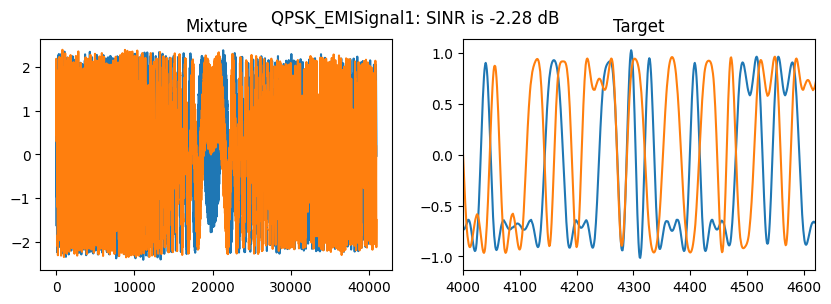

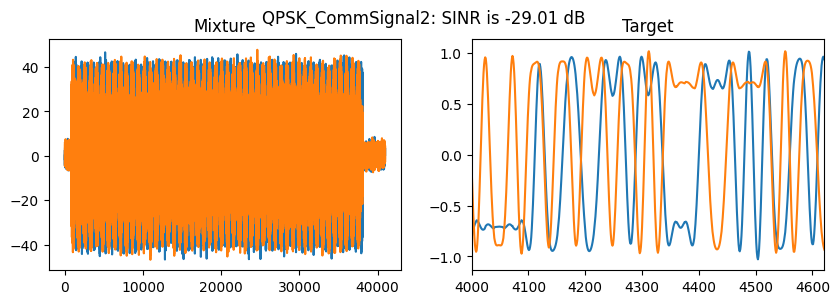

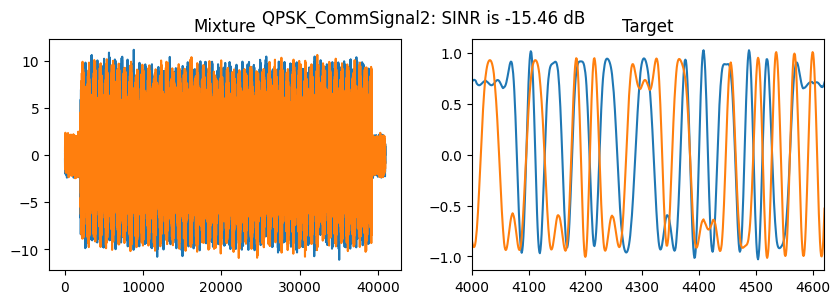

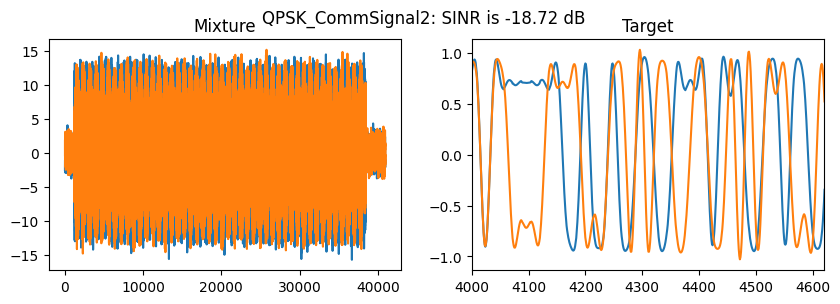

In [7]:
intrf_signal_set = ["CommSignal2",
                    "CommSignal3", "CommSignal5G1", "EMISignal1"]
for (soi_mix, soi_target, msg_bits, intrf_type, sinr) in train_loader:
    for i in range(batch_size):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes[0].plot(soi_mix[i, :, :].numpy().T)
        axes[0].set_title("Mixture")
        axes[1].plot(soi_target[i, :, :].numpy().T)
        axes[1].set_title("Target")
        fig.suptitle("{}_{}: SINR is {:.2f} dB".format(
            soi_type, intrf_signal_set[intrf_type[i].item()], sinr[i].item()))
        plt.xlim([4000, 4620])
        plt.show()
    break

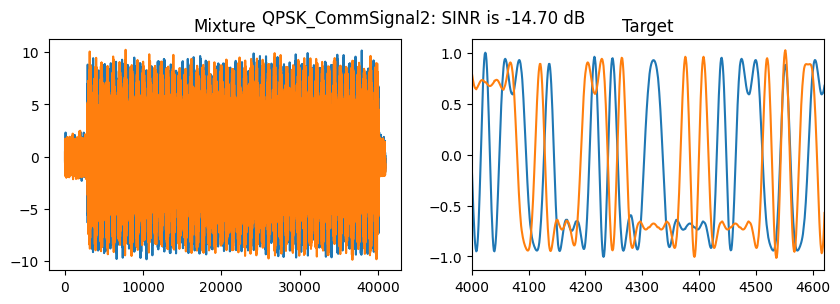

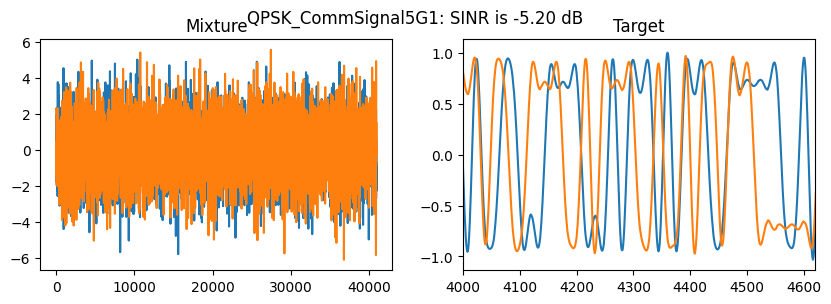

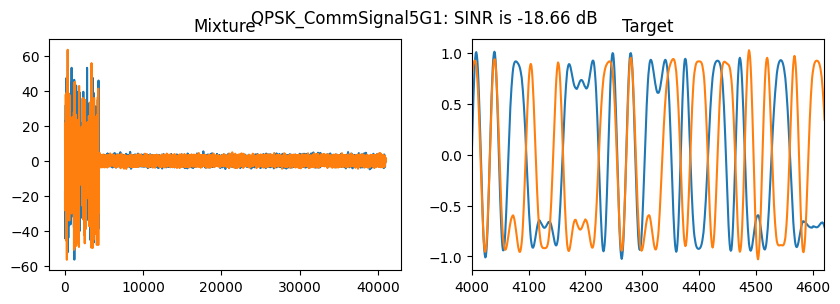

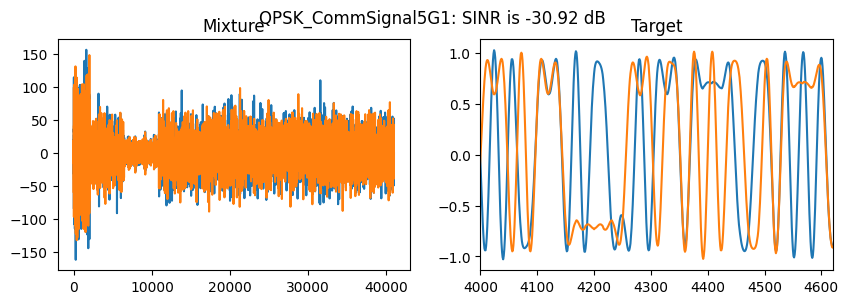

In [8]:
for (soi_mix, soi_target, msg_bits, intrf_type, sinr) in val_loader:
    for i in range(batch_size):
        fig, axes = plt.subplots(1, 2, figsize=(10, 3))
        axes[0].plot(soi_mix[i, :, :].numpy().T)
        axes[0].set_title("Mixture")
        axes[1].plot(soi_target[i, :, :].numpy().T)
        axes[1].set_title("Target")
        fig.suptitle("{}_{}: SINR is {:.2f} dB".format(
            soi_type, intrf_signal_set[intrf_type[i].item()], sinr[i].item()))
        plt.xlim([4000, 4620])
        plt.show()
    break

In [9]:
model_params = {
    "input_channels": 2,
    "residual_channels": 256,
    "residual_layers": 30,
    "dilation_cycle_length": 10
}

model = WaveNet(**model_params).to(device)
"The model has {} million parameters".format(
    sum(p.numel() for p in model.parameters()) / 1e6)

'The model has 5.325314 million parameters'

In [10]:
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()
criterion = nn.MSELoss()

In [11]:
history = {
    "train_loss": [],
    "val_loss": []
}


top_k_checkpoints = 3
best_val_losses = [float("inf")] * top_k_checkpoints
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")

for epoch in range(EPOCHS):
    print("Epoch: {}".format(epoch+1))
    model.train()
    avg_tloss = 0.0
    for i, (soi_mix, soi_target, _, _, _) in enumerate(train_loader):
        soi_mix, soi_target = soi_mix.to(device), soi_target.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            soi_est = model(soi_mix)
            loss = criterion(soi_est, soi_target)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        avg_tloss += loss.item()

    avg_tloss /= len(train_loader)
    print("\ttrain loss: {:.4f}".format(avg_tloss))
    history["train_loss"].append(avg_tloss)

    model.eval()
    avg_vloss = 0.0
    for i, (soi_mix, soi_target, _, _, _) in enumerate(val_loader):
        soi_mix, soi_target = soi_mix.to(device), soi_target.to(device)
        with torch.no_grad():
            soi_est = model(soi_mix)
            loss = criterion(soi_est, soi_target)
        avg_vloss += loss.item()
    avg_vloss /= len(val_loader)
    print("\tval loss: {:.4f}".format(avg_vloss))
    history["val_loss"].append(avg_vloss)

    # After updating avg_vloss and before saving the model
    if avg_vloss < max(best_val_losses):
        # Replace the max loss in best_val_losses with the current avg_vloss
        max_best_val_loss = max(best_val_losses)
        max_loss_index = best_val_losses.index(max_best_val_loss)
        best_val_losses[max_loss_index] = avg_vloss
        # Save model as before
        model_path = f"checkpoints/KUTII_WaveNet-epoch_{epoch+1}_vloss_{avg_vloss}.pt"
        model_checkpoint = {
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "loss": avg_vloss
        }
        torch.save(model_checkpoint, model_path)
        print(f"Model saved to {model_path}")
        # delete replaced checkpoint
        for file in os.listdir("checkpoints"):
            if file.endswith(f"vloss_{max_best_val_loss}.pt"):
                os.remove(f"checkpoints/{file}")

Epoch: 1
	train loss: 0.4071
	val loss: 0.3806
Model saved to checkpoints/KUTII_WaveNet-epoch_1_vloss_0.3805536448955536.pt
Epoch: 2
	train loss: 0.3552
	val loss: 0.3668
Model saved to checkpoints/KUTII_WaveNet-epoch_2_vloss_0.36678726375103.pt
Epoch: 3
	train loss: 0.3410
	val loss: 0.3651
Model saved to checkpoints/KUTII_WaveNet-epoch_3_vloss_0.3651198744773865.pt
Epoch: 4
	train loss: 0.3260
	val loss: 0.3529
Model saved to checkpoints/KUTII_WaveNet-epoch_4_vloss_0.3529416799545288.pt
Epoch: 5
	train loss: 0.3177
	val loss: 0.3422
Model saved to checkpoints/KUTII_WaveNet-epoch_5_vloss_0.34222088754177094.pt
Epoch: 6
	train loss: 0.3042
	val loss: 0.3350
Model saved to checkpoints/KUTII_WaveNet-epoch_6_vloss_0.33498040288686753.pt
Epoch: 7
	train loss: 0.2983
	val loss: 0.3316
Model saved to checkpoints/KUTII_WaveNet-epoch_7_vloss_0.3315639168024063.pt
Epoch: 8
	train loss: 0.2921
	val loss: 0.3342
Model saved to checkpoints/KUTII_WaveNet-epoch_8_vloss_0.33421107977628706.pt
Epoch: 

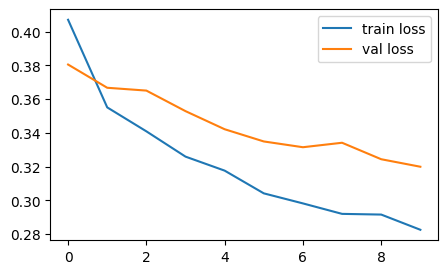

In [12]:
# visualize the losses

plt.figure(figsize=(5, 3))
plt.plot(history["train_loss"], label="train loss")
plt.plot(history["val_loss"], label="val loss")
plt.legend()

In [19]:
# load save checkpoint
model.load_state_dict(torch.load(model_path)["state_dict"])

<All keys matched successfully>

In [20]:
test_datset_path, _, _ = generate_competition_eval_mixture(soi_type=soi_type,
                                                     intrf_path_dir="rf_datasets/train_test_set_unmixed/dataset/testset1_frame")
test_dataset = SigSepDataset(test_datset_path, dtype="real")
# test_dataset = SigSepDataset("rf_datasets/test_set_mixed/datasets/eval_QPSK_20240404_153741", dtype="real")
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
model.eval()

results = {
    key: {
        "sinr_all": [],
        "soi_target_all": [],
        "soi_est_all": [],
        "msg_bits_all": [],
        "soi_no_mitigation_all": [],
    } for key in intrf_signal_set
}


for i, (soi_mix, soi_target, msg_bits, intrf_type, sinr) in enumerate(test_loader):
    soi_mix = soi_mix.to(device)
    with torch.no_grad():
        soi_est = model(soi_mix)
    for idx, int_type in enumerate(intrf_signal_set):
        results[int_type]["sinr_all"].extend(sinr[intrf_type == idx].numpy())
        results[int_type]["soi_target_all"].extend(
            soi_target[intrf_type == idx].numpy())
        results[int_type]["soi_est_all"].extend(
            soi_est[intrf_type == idx].cpu().numpy())
        results[int_type]["msg_bits_all"].extend(
            msg_bits[intrf_type == idx].numpy())
        results[int_type]["soi_no_mitigation_all"].extend(
            soi_mix[intrf_type == idx].cpu().numpy())

for intrf_type in intrf_signal_set:
    results[intrf_type]["sinr_all"] = np.array(results[intrf_type]["sinr_all"])
    results[intrf_type]["soi_target_all"] = np.array(
        results[intrf_type]["soi_target_all"])
    results[intrf_type]["soi_est_all"] = np.array(
        results[intrf_type]["soi_est_all"])
    results[intrf_type]["msg_bits_all"] = np.array(
        results[intrf_type]["msg_bits_all"])
    results[intrf_type]["soi_no_mitigation_all"] = np.array(
        results[intrf_type]["soi_no_mitigation_all"])

In [22]:
results, results["CommSignal2"]["soi_target_all"].shape

({'CommSignal2': {'sinr_all': array([-30.26274872, -30.26201439, -30.25838089, ...,  -0.26127326,
           -0.25987941,  -0.26124603]),
   'soi_target_all': array([[[ 0.46526772,  0.55553794,  0.63999516, ..., -0.5116268 ,
            -0.46394894, -0.4129288 ],
           [ 0.35915768,  0.41292882,  0.46394888, ...,  0.71509194,
             0.63999516,  0.555538  ]],
   
          [[-0.35309428, -0.41878307, -0.4829919 , ...,  0.5441412 ,
             0.4829919 ,  0.41878307],
           [ 0.35915768,  0.41292882,  0.46394888, ...,  0.53531253,
             0.48625427,  0.43227997]],
   
          [[ 0.46526772,  0.55553794,  0.63999516, ...,  0.5116268 ,
             0.46394894,  0.4129288 ],
           [-0.3379357 , -0.39943188, -0.46068653, ...,  0.73877764,
             0.6623005 ,  0.5748892 ]],
   
          ...,
   
          [[-0.35915768, -0.41292882, -0.46394888, ..., -0.7239205 ,
            -0.6367328 , -0.54204106],
           [ 0.45920432,  0.5613923 ,  0.6590381 , ...

In [23]:
# post processing and evaluation
# combine IQ channels
for intrf_type in intrf_signal_set:
    results[intrf_type]["soi_target_all"] = results[intrf_type]["soi_target_all"][:, 0, :] + \
        1j * results[intrf_type]["soi_target_all"][:, 1, :]
    results[intrf_type]["soi_est_all"] = results[intrf_type]["soi_est_all"][:, 0, :] + \
        1j * results[intrf_type]["soi_est_all"][:, 1, :]
    results[intrf_type]["soi_no_mitigation_all"] = results[intrf_type]["soi_no_mitigation_all"][:, 0, :] + \
        1j * results[intrf_type]["soi_no_mitigation_all"][:, 1, :]

In [25]:
results["CommSignal2"]["soi_target_all"].shape

(1100, 40960)

In [30]:
from comm_utils import qpsk_helper

In [28]:
def get_db(p): return 10*np.log10(p)
def get_pow(s): return np.mean(np.abs(s)**2, axis=-1)
def get_sinr(s, i): return get_pow(s)/get_pow(i)
def get_sinr_db(s, i): return get_db(get_sinr(s, i))

def get_mse(y, yhat): return np.mean(np.abs(y - yhat)**2, axis=-1)
def get_ber(b, bhat): return np.mean(b != bhat, axis=-1).astype(np.float32)

In [40]:
# evaluate the mse and ber
eval_metrics = {
    key: {
        "sinr_all": [],
        "mse_no_mitigation": [],
        "mse_est": [],
        "ber_no_mitigation": [],
        "ber_est": []
    } for key in intrf_signal_set
}

for intrf_type in intrf_signal_set:
    y = results[intrf_type]["soi_target_all"]
    yhat = results[intrf_type]["soi_no_mitigation_all"]
    eval_metrics[intrf_type]["mse_no_mitigation"] = get_db(get_mse(y, yhat))
    yhat = results[intrf_type]["soi_est_all"]
    eval_metrics[intrf_type]["mse_est"] = get_db(get_mse(y, yhat))

    # demodulate the signals
    b = results[intrf_type]["msg_bits_all"]
    bhat, _ = qpsk_helper.demodulate_qpsk_signal(results[intrf_type]["soi_no_mitigation_all"])
    eval_metrics[intrf_type]["ber_no_mitigation"] = get_ber(b, bhat)
    bhat, _ = qpsk_helper.demodulate_qpsk_signal(results[intrf_type]["soi_est_all"])
    eval_metrics[intrf_type]["ber_est"] = get_ber(b, bhat)

    # save the sinr
    eval_metrics[intrf_type]["sinr_all"] = results[intrf_type]["sinr_all"]

In [33]:
def get_smoothed(sinr, ber, npoints=50):
    bins = np.linspace(sinr.min(), sinr.max(), npoints)
    bin_means, bin_edges, _ = binned_statistic(
        sinr, ber, statistic='mean', bins=bins)

    # To plot the line at the center of the bins, calculate the bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, bin_means

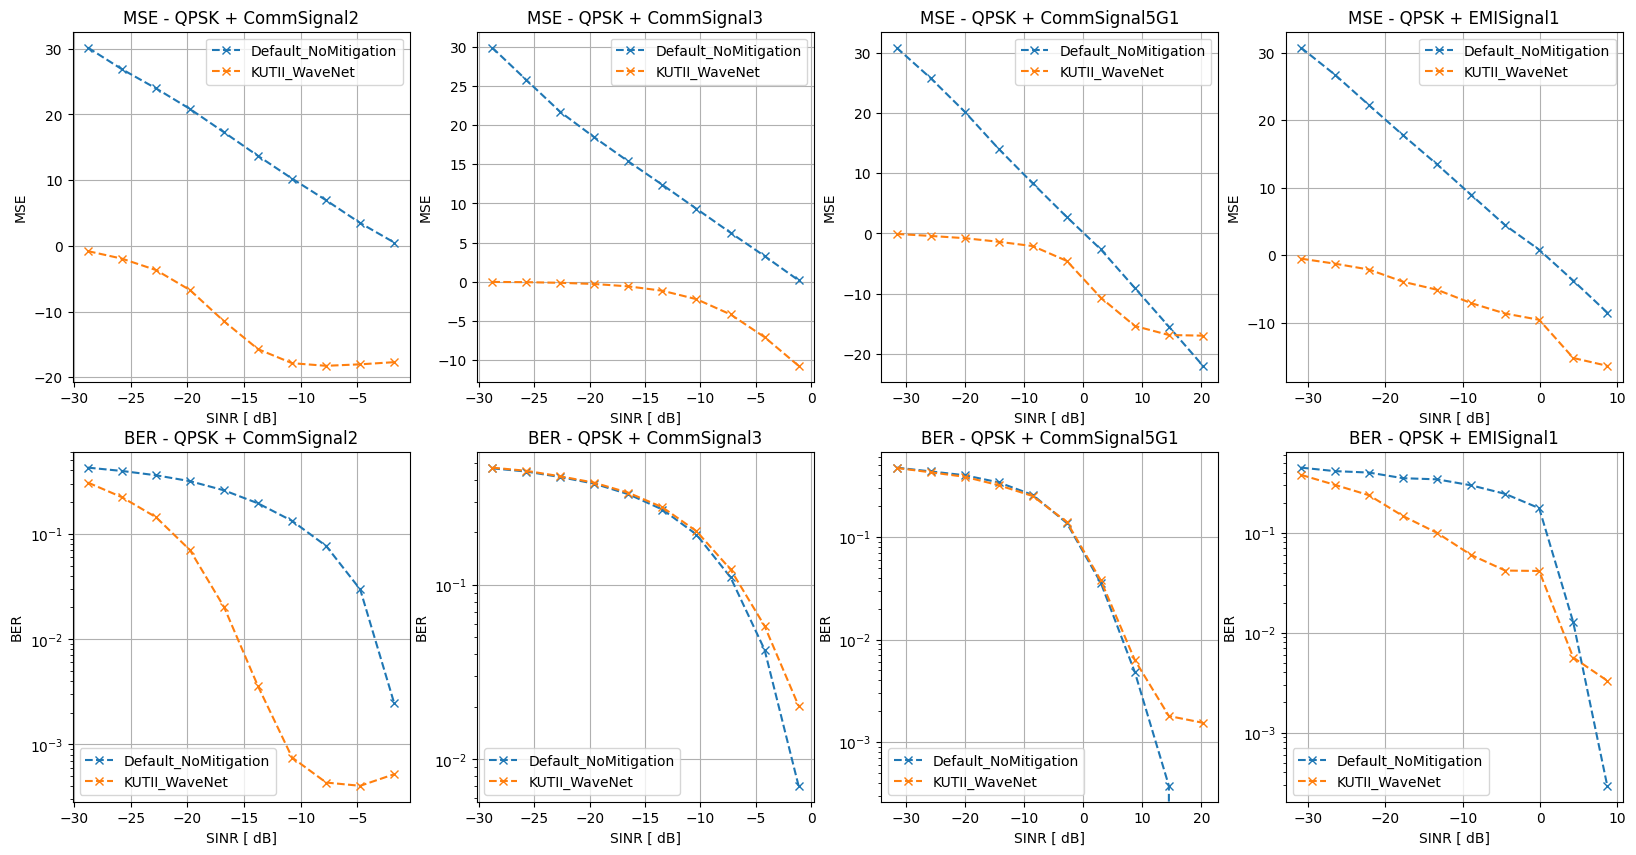

In [46]:
fig = plt.figure(figsize=(20, 10))

gs = GridSpec(2, 4, figure=fig)

for i, intrf_type in enumerate(intrf_signal_set):
    ax = fig.add_subplot(gs[0, i])
    sinr_all = eval_metrics[intrf_type]["sinr_all"]
    mse_no_mitigation = eval_metrics[intrf_type]["mse_no_mitigation"]
    ax.plot(*get_smoothed(sinr_all, mse_no_mitigation, 11), "x--", label="Default_NoMitigation")
    mse_est = eval_metrics[intrf_type]["mse_est"]
    ax.plot(*get_smoothed(sinr_all, mse_est, 11), "x--", label="KUTII_WaveNet")
    ax.grid()
    ax.legend()
    ax.title.set_text(f"MSE - {soi_type} + {intrf_type}")
    ax.set_xlabel("SINR [ dB]")
    ax.set_ylabel("MSE")

    ax = fig.add_subplot(gs[1, i])
    ber_no_mitigation = eval_metrics[intrf_type]["ber_no_mitigation"]
    ax.semilogy(*get_smoothed(sinr_all, ber_no_mitigation, 11), "x--", label="Default_NoMitigation")
    ber_est = eval_metrics[intrf_type]["ber_est"]
    ax.semilogy(*get_smoothed(sinr_all, ber_est, 11), "x--", label="KUTII_WaveNet")
    ax.grid()
    ax.legend()
    ax.title.set_text(f"BER - {soi_type} + {intrf_type}")
    ax.set_xlabel("SINR [ dB]")
    ax.set_ylabel("BER")   
